# FedAP
该Notebook使用隐语框架基于论文 [Personalized Federated Learning with Adaptive Batchnorm for Healthcare](https://arxiv.org/abs/2112.00734) 中提出的 FedAP 策略完成个性化联邦在OrganCMNIST数据集上的实验，并与FedAvg,FedBN,FedPer策略进行对比实验。参考代码来自原论文：https://github.com/jindongwang/tlbook-code/tree/main/chap19_fl
请从该链接下载数据集并放置在 ./data目录下：https://zenodo.org/record/5208230/files/organcmnist.npz?download=1
并从https://github.com/jindongwang/tlbook-code/tree/main/chap19_fl中下载partion_0.05.npy放置在./split/organcmnist目录下

## 创建预训练模型
首先创建预训练模型用于计算各个客户端初始BN层计算统计量

In [2]:
import os, sys
import numpy as np
import math
import torch
import copy
import torch.optim as optim
import torch.nn as nn
from models import *
from util import *
from dataloader_medmnist import *
import datasplit
import copy
from fedhealth import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
args = config(batch=32, wk_iters=1, iters=400)
args.data = "organcmnist"
datasetname = []
args.n_clients = 20
for i in range(args.n_clients):
    datasetname.append("organcmnist_" + str(i))
os.makedirs("./checkpoint/" + "pretrained/", exist_ok=True)
preckpt = "./checkpoint/" + "pretrained/" + args.data + "_" + str(args.batch)
if not os.path.exists(preckpt):
    pretrained(args, preckpt)

train_loaders, test_loaders包含20个客户端的训练测试数据，使用预训练模型和数据为20个客户端计算相似度矩阵weight_m

In [3]:
client_num = 20
client_weights = [1 / client_num for i in range(client_num)]
args = config(batch=1, wk_iters=1, iters=400, n_clients=20)
train_loaders, test_loaders = prepare_data(args)
weight_m = get_weight_preckpt(args, preckpt, train_loaders, client_weights)
weight_m.shape

(20, 20)

In [4]:
weight_m[0]  # 每一行是当前客户端的相似度矩阵

array([0.5       , 0.03021549, 0.00825077, 0.01218688, 0.03201974,
       0.0197568 , 0.00731586, 0.02505977, 0.02288137, 0.02325427,
       0.00874053, 0.00574451, 0.01768603, 0.08448838, 0.03265906,
       0.02563228, 0.02423882, 0.05097286, 0.03137153, 0.03752506])

## 设置模型和训练参数
初始化客户端

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print("The version of SecretFlow: {}".format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(["client" + str(i) for i in range(1, 21)] + ["charlie"], address="local")

clients = [sf.PYU("client" + str(i)) for i in range(1, 21)]
charlie = sf.PYU("charlie")

The version of SecretFlow: 1.3.0.dev20231206


2023-12-20 10:49:40,338	INFO worker.py:1538 -- Started a local Ray instance.


In [194]:
(
    client1,
    client2,
    client3,
    client4,
    client5,
    client6,
    client7,
    client8,
    client9,
    client10,
    client11,
    client12,
    client13,
    client14,
    client15,
    client16,
    client17,
    client18,
    client19,
    client20,
    charlie,
) = clients + [charlie]

# 初始化20个客户端的parts字典
parts = {client: 0.05 for client in clients}

In [64]:
from secretflow.ml.nn.utils import BaseModule, TorchModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator, PlainAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

In [124]:
class lenet5_test(BaseModule):
    def __init__(self):
        super(lenet5_test, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 11)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.bn2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

将各个客户端的数据集转换为适合隐语训练框架的格式

In [44]:
from typing import Dict, List, Tuple, Union
import numpy as np
from secretflow.data.ndarray import FedNdarray, PartitionWay
from secretflow.device.device.pyu import PYU
from torchvision import transforms
from torch.utils.data import DataLoader


def _convert_to_fedndarray1(dataloaders, parts, is_torch):
    pyu_data = {}
    pyu_labels = {}
    for pyu, dataloader in zip(parts.keys(), dataloaders):
        data_list = []
        label_list = []
        for data, label in dataloader:
            if is_torch:
                data = data.numpy()
                label = label.numpy()
            data_list.append(data)
            label_list.append(label)
        pyu_data[pyu] = np.concatenate(data_list)
        pyu_labels[pyu] = np.concatenate(label_list)

    data_fedndarray = FedNdarray(
        partitions={pyu: pyu(lambda arr: arr)(pyu_data[pyu]) for pyu in parts.keys()},
        partition_way=PartitionWay.HORIZONTAL,
    )

    labels_fedndarray = FedNdarray(
        partitions={pyu: pyu(lambda arr: arr)(pyu_labels[pyu]) for pyu in parts.keys()},
        partition_way=PartitionWay.HORIZONTAL,
    )

    return data_fedndarray, labels_fedndarray


def load_organcmnist(
    parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
    train_loaders,
    test_loaders,
    batch_size: int = 1,
    is_torch: bool = True,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    train_data, train_labels = _convert_to_fedndarray1(train_loaders, parts, is_torch)
    test_data, test_labels = _convert_to_fedndarray1(test_loaders, parts, is_torch)

    return ((train_data, train_labels), (test_data, test_labels))

自定义加权服务器聚合方法，依据权重矩阵weight_m计算各个客户端下轮更新获得的参数，注意当权重矩阵变更时需要重新加载该单元格

In [45]:
def server_agg_method(model_params_list, weight_matrix=weight_m):
    """
    根据权重矩阵更新每个客户端的模型参数。
    model_params_list是一个嵌套列表，每个客户端包含一系列层的参数，每层的参数可能是不同形状的数组。
    Args:
        model_params_list: 模型参数列表，每个元素是一个客户端的模型参数列表，其中包含该客户端所有层的参数。
        weight_matrix: 客户端间权重矩阵，每一行代表对应客户端的权重配置。

    Returns:
        更新后的模型参数列表，结构与model_params_list相同。
    """

    client_num = len(model_params_list)
    num_layers = len(model_params_list[0])
    updated_params_list = [[] for _ in range(client_num)]

    for layer_idx in range(num_layers):
        # 提取所有客户端相同层的参数
        layer_params = [client_params[layer_idx] for client_params in model_params_list]
        # 对该层的参数进行加权平均
        for client_idx in range(client_num):
            # 取出当前客户端的权重
            client_weights = weight_matrix[client_idx]
            # 计算加权平均
            weighted_sum = np.zeros_like(layer_params[0], dtype=float)
            for other_client_idx in range(client_num):
                weighted_sum += (
                    client_weights[other_client_idx] * layer_params[other_client_idx]
                )
            updated_params_list[client_idx].append(weighted_sum)

    # 返回更新后的模型参数列表
    return updated_params_list

初始化训练参数，注意organcmnist数据集是11类分类任务

In [195]:
(train_data, train_label), (test_data, test_label) = load_organcmnist(
    parts=parts,
    train_loaders=train_loaders,
    test_loaders=test_loaders,
)

loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.SGD, lr=0.01)
model_def = TorchModel(
    model_fn=lenet5_test,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=11, average="micro"),
        metric_wrapper(Precision, task="multiclass", num_classes=11, average="micro"),
    ],
)

## 使用不同策略训练
先运行对应策略初始化参数单元格，再运行开始训练单元格

### FedAP
FedAP策略，同参考代码，此处的fed_ap实际上在是fed_bn策略基础上，使用预训练模型计算的客户端权重相似度矩阵加权聚合BN层之外的模型权重，客户端权重相似度矩阵在训练过程中不更新

In [ ]:
device_list = clients
server = charlie

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    server_agg_method=server_agg_method,
    strategy="fed_ap",  # fl strategy
    backend="torch",
)

### 其他策略
使用fedavg，fedbn，fedper前，因为各客户端样本数相等，将权重矩阵改为均等

In [135]:
num_clients = 20
client_weight = 1.0 / num_clients
# Create a 20x20 weight matrix with each element being 0.05
weight_m = np.full((num_clients, num_clients), client_weight)
weight_m.shape

(20, 20)

In [151]:
weight_m[0]

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [154]:
def server_agg_method(model_params_list, weight_matrix=weight_m):
    """
    根据权重矩阵更新每个客户端的模型参数。
    model_params_list是一个嵌套列表，每个客户端包含一系列层的参数，每层的参数可能是不同形状的数组。
    Args:
        model_params_list: 模型参数列表，每个元素是一个客户端的模型参数列表，其中包含该客户端所有层的参数。
        weight_matrix: 客户端间权重矩阵，每一行代表对应客户端的权重配置。

    Returns:
        更新后的模型参数列表，结构与model_params_list相同。
    """

    client_num = len(model_params_list)
    num_layers = len(model_params_list[0])
    updated_params_list = [[] for _ in range(client_num)]

    for layer_idx in range(num_layers):
        # 提取所有客户端相同层的参数
        layer_params = [client_params[layer_idx] for client_params in model_params_list]
        # 对该层的参数进行加权平均
        for client_idx in range(client_num):
            # 取出当前客户端的权重
            client_weights = weight_matrix[client_idx]
            # 计算加权平均
            weighted_sum = np.zeros_like(layer_params[0], dtype=float)
            for other_client_idx in range(client_num):
                weighted_sum += (
                    client_weights[other_client_idx] * layer_params[other_client_idx]
                )
            updated_params_list[client_idx].append(weighted_sum)

    # 返回更新后的模型参数列表
    return updated_params_list

#### FedAvg策略

In [ ]:
device_list = clients
server = charlie

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    server_agg_method=server_agg_method,
    strategy="fed_avg_w",  # fl strategy
    backend="torch",
)

#### FedBN策略
仍然使用strategy='fed_ap'，但是改为各客户端使用相等权重聚合

In [ ]:
device_list = clients
server = charlie

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    server_agg_method=server_agg_method,
    strategy="fed_ap",  # fl strategy
    backend="torch",
)

#### FedPer策略
Kp=2将最后一个全连接层作为客户端个性化层

In [ ]:
device_list = clients
server = charlie

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    server_agg_method=server_agg_method,
    strategy="fed_per",  # fl strategy
    backend="torch",
    Kp=2,
)

### 开始训练

In [ ]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=200,
    # epochs=400,
    batch_size=32,
    aggregate_freq=1,
)

## 训练结果
绘制训练结果

In [ ]:
from matplotlib import pyplot as plt


def plot_accuracy_all_clients(history, method_name):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"{method_name} test accuracy for all clients")

    # Plot for clients 1-5
    axs[0, 0].plot(history["local_history"]["client1_val_eval_multiclassaccuracy"])
    axs[0, 0].plot(history["local_history"]["client2_val_eval_multiclassaccuracy"])
    axs[0, 0].plot(history["local_history"]["client3_val_eval_multiclassaccuracy"])
    axs[0, 0].plot(history["local_history"]["client4_val_eval_multiclassaccuracy"])
    axs[0, 0].plot(history["local_history"]["client5_val_eval_multiclassaccuracy"])
    axs[0, 0].set_title("Clients 1-5")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].legend(
        ["client1", "client2", "client3", "client4", "client5"], loc="upper left"
    )

    # Plot for clients 6-10
    axs[0, 1].plot(history["local_history"]["client6_val_eval_multiclassaccuracy"])
    axs[0, 1].plot(history["local_history"]["client7_val_eval_multiclassaccuracy"])
    axs[0, 1].plot(history["local_history"]["client8_val_eval_multiclassaccuracy"])
    axs[0, 1].plot(history["local_history"]["client9_val_eval_multiclassaccuracy"])
    axs[0, 1].plot(history["local_history"]["client10_val_eval_multiclassaccuracy"])
    axs[0, 1].set_title("Clients 6-10")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].legend(
        ["client6", "client7", "client8", "client9", "client10"], loc="upper left"
    )

    # Plot for clients 11-15
    axs[1, 0].plot(history["local_history"]["client11_val_eval_multiclassaccuracy"])
    axs[1, 0].plot(history["local_history"]["client12_val_eval_multiclassaccuracy"])
    axs[1, 0].plot(history["local_history"]["client13_val_eval_multiclassaccuracy"])
    axs[1, 0].plot(history["local_history"]["client14_val_eval_multiclassaccuracy"])
    axs[1, 0].plot(history["local_history"]["client15_val_eval_multiclassaccuracy"])
    axs[1, 0].set_title("Clients 11-15")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].legend(
        ["client11", "client12", "client13", "client14", "client15"], loc="upper left"
    )

    # Plot for clients 16-20
    axs[1, 1].plot(history["local_history"]["client16_val_eval_multiclassaccuracy"])
    axs[1, 1].plot(history["local_history"]["client17_val_eval_multiclassaccuracy"])
    axs[1, 1].plot(history["local_history"]["client18_val_eval_multiclassaccuracy"])
    axs[1, 1].plot(history["local_history"]["client19_val_eval_multiclassaccuracy"])
    axs[1, 1].plot(history["local_history"]["client20_val_eval_multiclassaccuracy"])
    axs[1, 1].set_title("Clients 16-20")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Accuracy")
    axs[1, 1].legend(
        ["client16", "client17", "client18", "client19", "client20"], loc="upper left"
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### FedAP各个客户端测试集accuracy

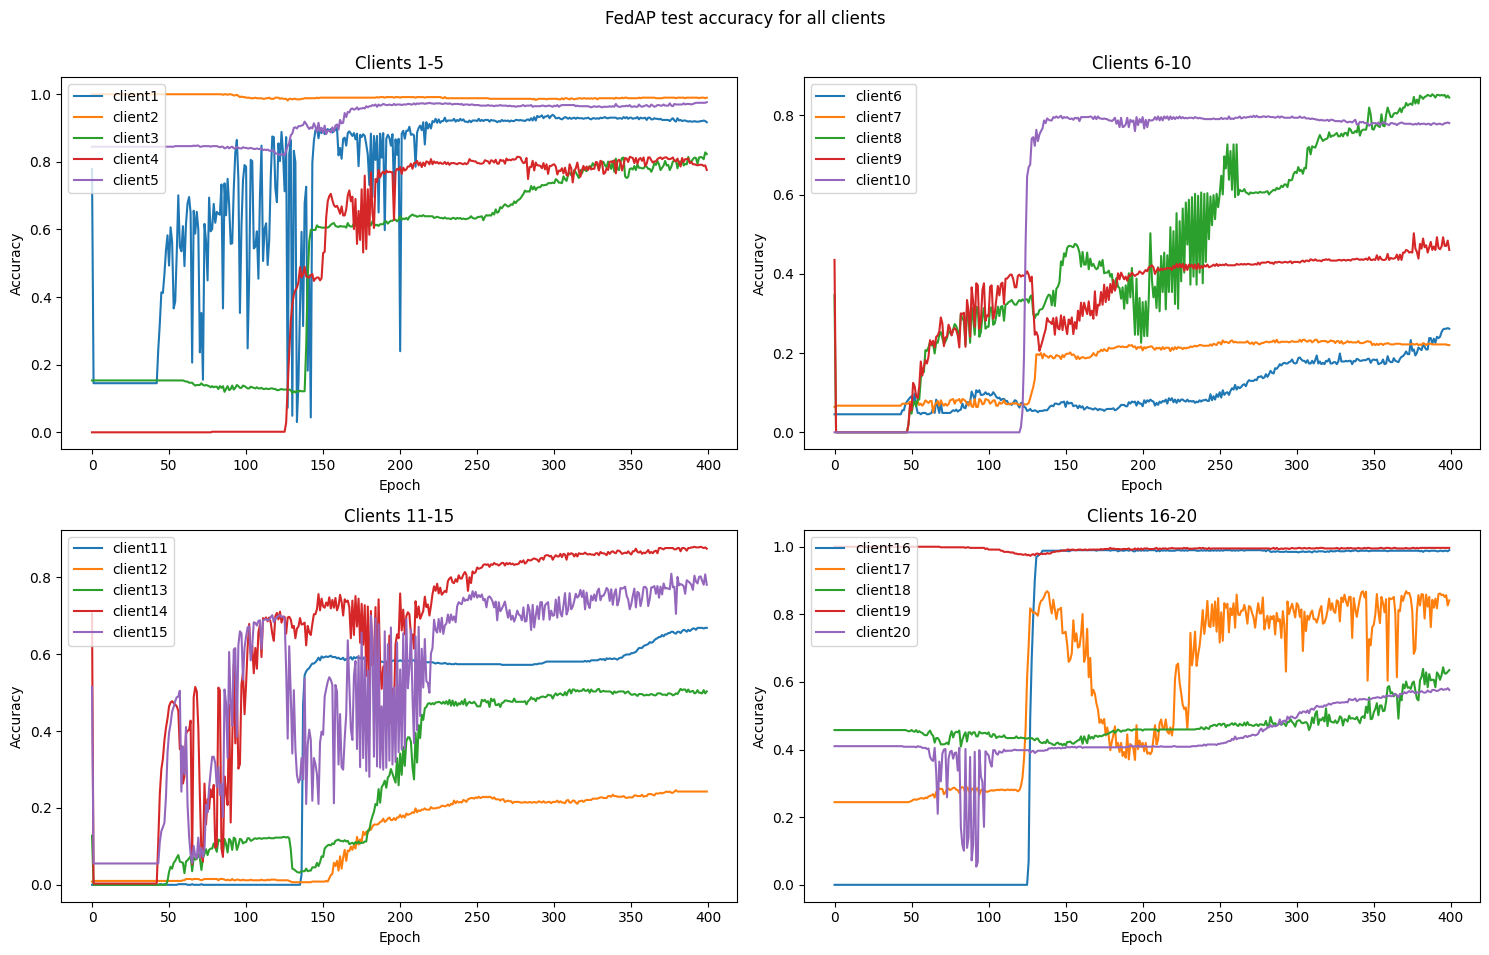

In [51]:
history_ap = history
plot_accuracy_all_clients(history_ap, "FedAP")

### FedAvg各个客户端测试集accuracy

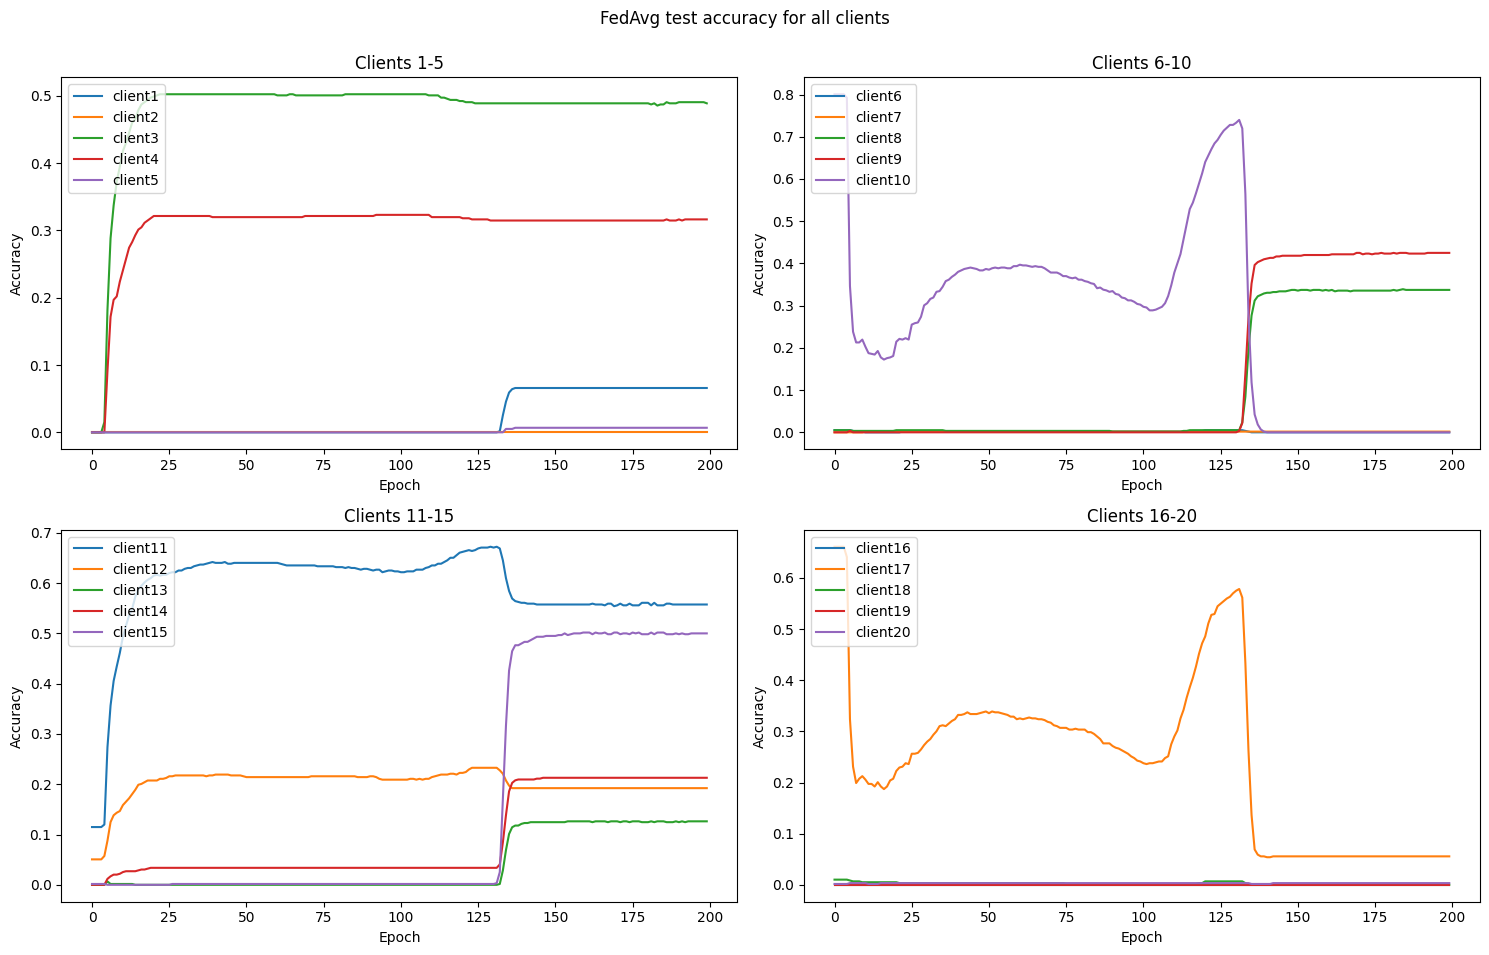

In [144]:
history_avg = history
plot_accuracy_all_clients(history_avg, "FedAvg")

### FedBN各个客户端测试集accuracy

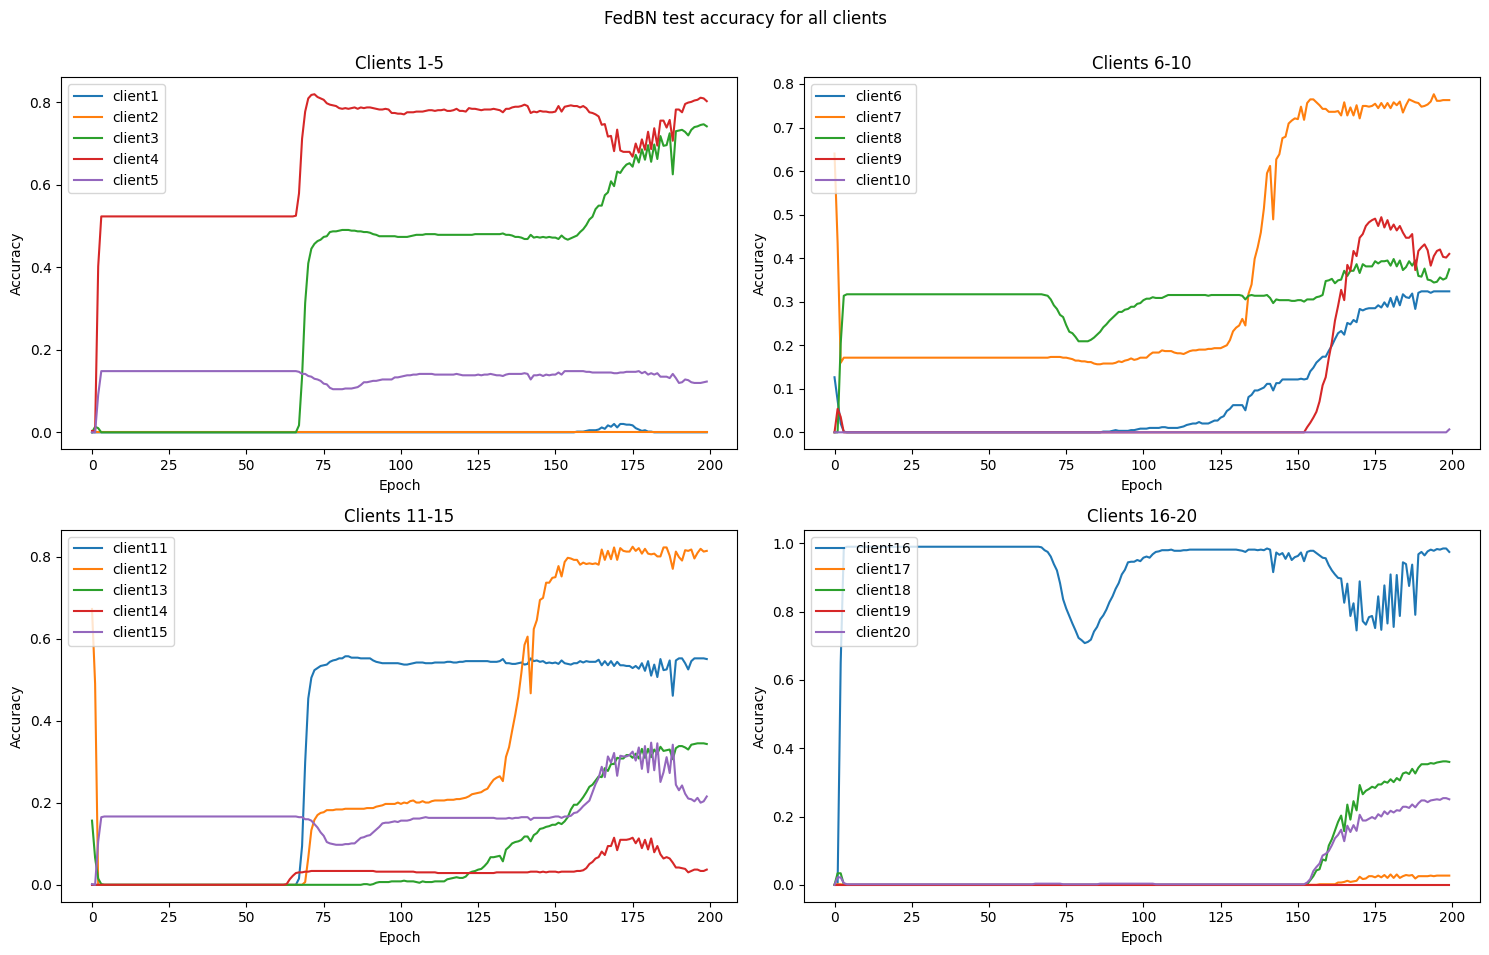

In [157]:
history_bn = history
plot_accuracy_all_clients(history_bn, "FedBN")

### FedPer各个客户端测试集accuracy

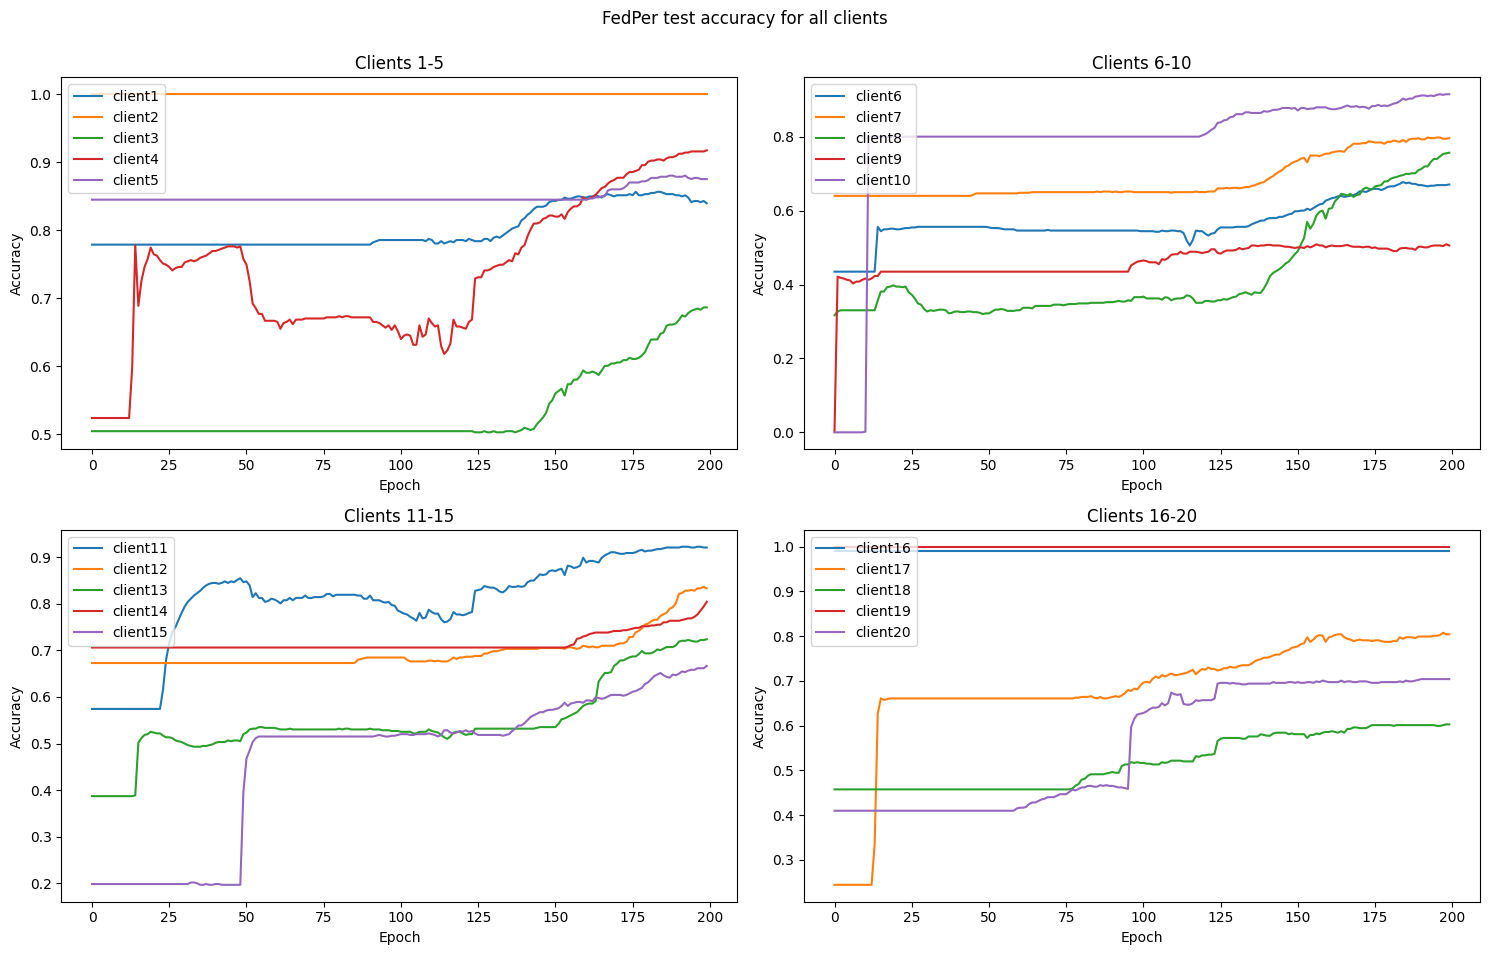

In [164]:
history_per = history
plot_accuracy_all_clients(history_per, "FedPer")

### 不同策略全局平均测试集accuracy对比

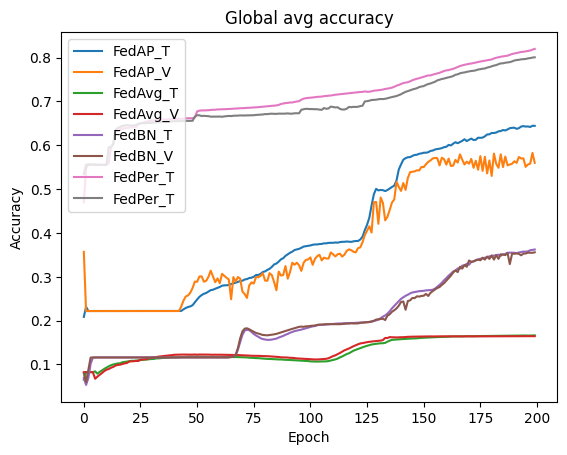

In [177]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history_ap["global_history"]["multiclassaccuracy"])
plt.plot(history_ap["global_history"]["val_multiclassaccuracy"])
plt.plot(history_avg["global_history"]["multiclassaccuracy"])
plt.plot(history_avg["global_history"]["val_multiclassaccuracy"])
plt.plot(history_bn["global_history"]["multiclassaccuracy"])
plt.plot(history_bn["global_history"]["val_multiclassaccuracy"])
plt.plot(history_per["global_history"]["multiclassaccuracy"])
plt.plot(history_per["global_history"]["val_multiclassaccuracy"])
plt.title("Global avg accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(
    [
        "FedAP_T",
        "FedAP_V",
        "FedAvg_T",
        "FedAvg_V",
        "FedBN_T",
        "FedBN_V",
        "FedPer_T",
        "FedPer_T",
    ],
    loc="upper left",
)
plt.show()

### 数据统计
显示FedAP次于FedPer策略，可能是因为没有使用论文描述的在训练过程中更新客户端权重相似矩阵的操作。由于超参数和实验环境的区别，实验数据仅供参考。

In [169]:
import pandas as pd


def extract_accuracy(history, key_prefix):
    return [
        history["local_history"][f"{key_prefix}{i}_val_eval_multiclassaccuracy"][-1]
        for i in range(1, 21)
    ] + [history["global_history"]["val_multiclassaccuracy"][-1]]


accuracy_ap = extract_accuracy(history_ap, "client")
accuracy_avg = extract_accuracy(history_avg, "client")
accuracy_bn = extract_accuracy(history_bn, "client")
accuracy_per = extract_accuracy(history_per, "client")

accuracy_df = pd.DataFrame(
    {
        "Client": list(range(1, 21)) + ["avg"],
        "FedAvg": accuracy_avg,
        "FedBN": accuracy_bn,
        "FedPer": accuracy_per,
        "FedAP": accuracy_ap,
    }
)

print(accuracy_df)

   Client          FedAvg           FedBN          FedPer           FedAP
0       1  tensor(0.0659)      tensor(0.)  tensor(0.8395)  tensor(0.9172)
1       2      tensor(0.)      tensor(0.)      tensor(1.)  tensor(0.9899)
2       3  tensor(0.4890)  tensor(0.7420)  tensor(0.6863)  tensor(0.8229)
3       4  tensor(0.3165)  tensor(0.8030)  tensor(0.9175)  tensor(0.7761)
4       5  tensor(0.0067)  tensor(0.1231)  tensor(0.8752)  tensor(0.9764)
5       6      tensor(0.)  tensor(0.3238)  tensor(0.6712)  tensor(0.2614)
6       7  tensor(0.0017)  tensor(0.7630)  tensor(0.7966)  tensor(0.2202)
7       8  tensor(0.3373)  tensor(0.3744)  tensor(0.7572)  tensor(0.8449)
8       9  tensor(0.4250)  tensor(0.4098)  tensor(0.5059)  tensor(0.4604)
9      10      tensor(0.)  tensor(0.0068)  tensor(0.9155)  tensor(0.7804)
10     11  tensor(0.5574)  tensor(0.5507)  tensor(0.9206)  tensor(0.6689)
11     12  tensor(0.1922)  tensor(0.8145)  tensor(0.8331)  tensor(0.2428)
12     13  tensor(0.1263)  tensor(0.34